In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [2]:
import torch
from Data import GraphDataset
from Models import GCNFeatureExtractor
from utils.train import train
import random
import numpy as np

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

In [47]:
set_seed(42)
use_pre_paired = True
learning_rate = 1e-4
epochs = 2500
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_size = 100
pooling = 'global_avg'
temperature = 0.1
patience = 500
alpha = 0.05

In [5]:
# load data 
from Data import load_graphs

basic_data, _ = load_graphs()

	Collected 1 sample from null_ops.
	Collected 4 samples from commutations.
	Collected 7 samples from equivalences.
	Collected 7 samples from combined.
Loaded 19 samples and 19 quantum circuits from subset.


## Basic transforms training

### Train-Validation-Test Split

In [6]:
from sklearn.model_selection import train_test_split
test_mask = torch.zeros(len(basic_data), dtype=torch.bool)
test_mask[12:14] = True
val_mask = torch.zeros(len(basic_data), dtype=torch.bool)
val_mask[14:17] = True

train_data = [basic_data[i] for i in range(len(basic_data)) if not test_mask[i] and not val_mask[i]]
val_data = [basic_data[i] for i in range(len(basic_data)) if val_mask[i]]
test_data = [basic_data[i] for i in range(len(basic_data)) if test_mask[i]]

# train_data, val_data = train_test_split(train_data, train_size=0.8, shuffle=True)
print('Data split:')
print('train:', len(train_data), '(', round((len(train_data) / len(basic_data)) * 100, 1), '%)')
print('val:', len(val_data), '(', round((len(val_data) / len(basic_data)) * 100, 1), '%)')
print('test:', len(test_data), '(', round((len(test_data) / len(basic_data)) * 100, 1), '%)')

train_dataset = GraphDataset(train_data, pre_paired=use_pre_paired)
val_dataset = GraphDataset(val_data, pre_paired=use_pre_paired)
test_dataset = GraphDataset(test_data, pre_paired=use_pre_paired)

Data split:
train: 14 ( 73.7 %)
val: 3 ( 15.8 %)
test: 2 ( 10.5 %)


In [7]:
batch_size = len(train_dataset)
print('Batch size:', batch_size)

Batch size: 14


### Check for correctness of data format (from circuit to graph features)

In [8]:
import numpy as np
import networkx as nx
def get_attr_matrix(graph):
    nodes_list = list(graph.nodes)
    nodes_view = graph.nodes(data=True)
    return np.array([nodes_view[node]['feature_vector'] for node in nodes_list])

In [9]:
# # Check if graphs in the dataset are correctly converted to PyTorch Geometric Data objects
# graphs = [basic_data[0][0:2]]
# dataset_1 = GraphDataset(graphs, pre_paired=use_pre_paired)

# data_1, data_2 = dataset_1[0]

# print("NODE FEATURES:")

# print(get_attr_matrix(graphs[0][0]))
# print(get_attr_matrix(graphs[0][1]))

# print("---")

# print(data_1.x)
# print(data_2.x)

# print("ADJACENCY:")

# print(nx.adjacency_matrix(graphs[0][0]).todense())
# print(nx.adjacency_matrix(graphs[0][1]).todense())

# print("---")

# print(data_1.edge_index)
# print(data_2.edge_index)

### Initialize models

In [10]:
# create a fully connected nn stacking fully connected layers and ReLU activations
out_dim_gnn = embedding_size
proj_out_dim = 64

fc_model = torch.nn.Sequential(
    torch.nn.Linear(out_dim_gnn, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, proj_out_dim),
)

In [11]:
n_features = train_dataset[0][0].x.shape[1] if use_pre_paired else train_dataset[0].x.shape[1]
print(f'Number of features in the dataset: {n_features}')

gnn = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy=pooling)
proj = fc_model

# No projection head
from Models import CLWrapper
model = CLWrapper(gnn).to(device)

Number of features in the dataset: 6


In [12]:
history = train(model, train_dataset, val_dataset,
                epochs=epochs, 
                batch_size=batch_size, 
                lr=learning_rate,
                tau= temperature, 
                device=device, 
                ema_alpha= alpha,
                patience= patience,
                verbose= False)


# check ema by setting alpha to 0 (should be constant)

Training:  39%|███▉      | 984/2500 [01:33<02:23, 10.55epoch/s, loss=0.0767, val_loss=1.1093, ema_val_loss=0.8062]

Early stopping due to no improvement in validation loss. Epochs run:  984
Restoring model to the state with the best validation loss.


<function matplotlib.pyplot.show(close=None, block=None)>

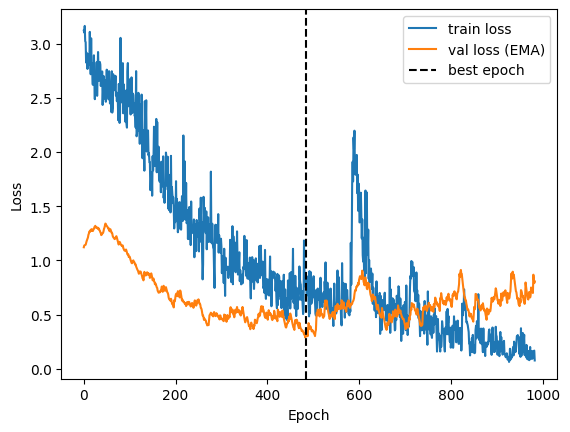

In [13]:
# plot loss trend during training
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['ema_val_loss'], label='val loss (EMA)')
# show epoch with best validation loss
best_epoch = len(history['ema_val_loss']) - patience
plt.axvline(best_epoch, color='black', linestyle='--', label='best epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [14]:
num_model_params = sum(p.numel() for p in model.parameters())
print(f'Number of model parameters: {num_model_params}')

Number of model parameters: 744300


In [15]:
# Now visualize what the model has learned
# Extract GNN
gnn_no_proj = model.gnn

pos1, pos2 = val_dataset[0]
neg1, neg2 = val_dataset[1]

# Extract embeddings
emb1 = gnn_no_proj(pos1)
emb2 = gnn_no_proj(pos2)

neg_emb1 = gnn_no_proj(neg1)
neg_emb2 = gnn_no_proj(neg2)

In [19]:
from utils.losses import NTXentLoss

print(f"Distance (L2 norm) among positive pair 1: {torch.norm(emb1 - emb2, dim=1).item()}")
print(f"Distance (L2 norm) among positive pair 2: {torch.norm(neg_emb1 - neg_emb2, dim=1).item()}")

print(f"Distance (L2 norm) among negative pair 1: {torch.norm(emb1 - neg_emb1, dim=1).item()}")
print(f"Distance (L2 norm) among negative pair 2: {torch.norm(emb2 - neg_emb2, dim=1).item()}")

Distance (L2 norm) among positive pair 1: 0.024625098332762718
Distance (L2 norm) among positive pair 2: 0.03586294874548912
Distance (L2 norm) among negative pair 1: 0.056945011019706726
Distance (L2 norm) among negative pair 2: 0.05379282310605049


In [20]:
# Now compute similarity between embeddings
from torch.nn.functional import cosine_similarity

print(f"Cosine similarity among positive pair 1: {cosine_similarity(emb1, emb2).item()}")
print(f"Cosine similarity among positive pair 2: {cosine_similarity(neg_emb1, neg_emb2).item()}")
print(f"Cosine similarity among negative pair 1: {cosine_similarity(emb1, neg_emb1).item()}")
print(f"Cosine similarity among negative pair 2: {cosine_similarity(emb2, neg_emb2).item()}")

Cosine similarity among positive pair 1: 0.8763442039489746
Cosine similarity among positive pair 2: 0.5935063362121582
Cosine similarity among negative pair 1: 0.10056182742118835
Cosine similarity among negative pair 2: 0.1696862280368805


In [21]:
# Show scores from NTXentLoss
ntxent = NTXentLoss(temperature)

z1 = torch.cat([emb1, neg_emb1], dim=0)
z2 = torch.cat([emb2, neg_emb2], dim=0)

loss, pos_score, neg_score = ntxent(z1, z2)

print(f"Loss: {loss.item()}")
print(f"Positive scores: {pos_score}")
print(f"Negative scores: {neg_score}")

Loss: 0.012622750364243984
Positive scores: tensor([[0.8763],
        [0.5935],
        [0.8763],
        [0.5935]], grad_fn=<ViewBackward0>)
Negative scores: tensor([[0.1006, 0.2137],
        [0.1006, 0.0484],
        [0.0484, 0.1697],
        [0.2137, 0.1697]], grad_fn=<ViewBackward0>)


### Now use a projector and do the same

In [22]:
gnn = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy=pooling)
model = CLWrapper(gnn, proj).to(device)

In [23]:
history = train(model, train_dataset, val_dataset,
                epochs=epochs, 
                batch_size=batch_size, 
                lr=learning_rate,
                tau= temperature, 
                device=device,
                ema_alpha= alpha,
                patience=patience, 
                verbose=False)

Training:  27%|██▋       | 670/2500 [01:05<02:58, 10.25epoch/s, loss=0.5577, val_loss=1.5124, ema_val_loss=1.3699]

Early stopping due to no improvement in validation loss. Epochs run:  670
Restoring model to the state with the best validation loss.


<function matplotlib.pyplot.show(close=None, block=None)>

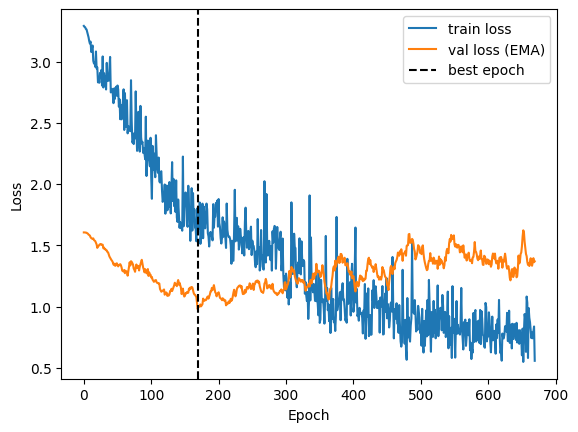

In [24]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['ema_val_loss'], label='val loss (EMA)')
# show epoch with best validation loss
best_epoch = len(history['ema_val_loss']) - patience
plt.axvline(best_epoch, color='black', linestyle='--', label='best epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [25]:
gnn_proj = model.gnn

# Extract embeddings
emb1 = gnn_proj(pos1)
emb2 = gnn_proj(pos2)

neg_emb1 = gnn_proj(neg1)
neg_emb2 = gnn_proj(neg2)

In [26]:
print(f"Distance (L2 norm) among positive pair 1: {torch.norm(emb1 - emb2, dim=1).item()}")
print(f"Distance (L2 norm) among positive pair 2: {torch.norm(neg_emb1 - neg_emb2, dim=1).item()}")

print(f"Distance (L2 norm) among negative pair 1: {torch.norm(emb1 - neg_emb1, dim=1).item()}")
print(f"Distance (L2 norm) among negative pair 2: {torch.norm(emb2 - neg_emb2, dim=1).item()}")

Distance (L2 norm) among positive pair 1: 0.11625584214925766
Distance (L2 norm) among positive pair 2: 0.3965306282043457
Distance (L2 norm) among negative pair 1: 1.4864338636398315
Distance (L2 norm) among negative pair 2: 1.2503048181533813


In [27]:
print(f"Cosine similarity among positive pair 1: {cosine_similarity(emb1, emb2).item()}")
print(f"Cosine similarity among positive pair 2: {cosine_similarity(neg_emb1, neg_emb2).item()}")
print(f"Cosine similarity among negative pair 1: {cosine_similarity(emb1, neg_emb1).item()}")
print(f"Cosine similarity among negative pair 2: {cosine_similarity(emb2, neg_emb2).item()}")

Cosine similarity among positive pair 1: 0.9978513121604919
Cosine similarity among positive pair 2: 0.9618076086044312
Cosine similarity among negative pair 1: 0.5767778754234314
Cosine similarity among negative pair 2: 0.7104505896568298


In [28]:
z1 = torch.cat([emb1, neg_emb1], dim=0)
z2 = torch.cat([emb2, neg_emb2], dim=0)

loss, pos_score, neg_score = ntxent(z1, z2)

print(f"Loss: {loss.item()}")
print(f"Positive scores: {pos_score}")
print(f"Negative scores: {neg_score}")

Loss: 0.08338601887226105
Positive scores: tensor([[0.9979],
        [0.9618],
        [0.9979],
        [0.9618]], grad_fn=<ViewBackward0>)
Negative scores: tensor([[0.5768, 0.7145],
        [0.5768, 0.5739],
        [0.5739, 0.7105],
        [0.7145, 0.7105]], grad_fn=<ViewBackward0>)


## Evaluate with Linear Evaluation

In [29]:
# Get two classes from dataset
class_1 = test_data[0]
class_2 = test_data[1]

In [30]:
class_1

In [31]:
from Data.Dataset import from_nx_to_geometric
# create labels vector
labels = torch.cat([torch.zeros(len(class_1)), torch.ones(len(class_2))]).long()

# create samples
data = [from_nx_to_geometric(g) for g in class_1 + class_2]
print(len(data))

# Split data into training and test set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

# WITHOUT PROJECTION HEAD
X_train_no_proj = torch.cat([gnn_no_proj(d) for d in X_train])
X_test_no_proj = torch.cat([gnn_no_proj(d) for d in X_test])

# WITH PROJECTION HEAD
X_train_proj = torch.cat([gnn_proj(d) for d in X_train])
X_test_proj = torch.cat([gnn_proj(d) for d in X_test])

print(labels.shape)
print(X_train_proj.shape)
print(X_test_proj.shape)

10
torch.Size([10])
torch.Size([8, 100])
torch.Size([2, 100])


In [32]:
print(X_train_proj)
print(X_train_no_proj)

tensor([[-1.8799e-01, -8.9922e-02, -2.3876e-01, -4.6476e-02,  1.4020e-01,
          6.8692e-02,  2.0125e-01,  1.1169e-01, -3.8993e-02, -1.1697e-01,
         -5.3458e-02, -1.4575e-01, -1.3218e-01, -1.4637e-01,  6.1797e-02,
          3.4232e-01,  1.1820e-02,  7.9449e-02,  1.0131e-01, -4.4100e-02,
          1.2029e-01,  6.3480e-02, -1.2860e-01,  1.1298e-01, -1.6771e-01,
         -2.5944e-02, -6.8324e-02, -1.6536e-01,  6.8687e-02,  5.3312e-02,
         -4.5867e-02,  2.0710e-02, -2.4958e-01,  2.1729e-02, -2.7370e-01,
         -6.9473e-02, -5.6754e-02,  3.0244e-02, -2.8359e-02,  1.3475e-01,
          5.1641e-02,  1.4585e-01,  2.2138e-01,  2.1291e-02,  4.0095e-02,
          2.2909e-01,  1.6436e-02, -1.1394e-01, -5.7511e-02, -1.9690e-01,
         -7.5200e-02,  1.2072e-01, -2.8355e-02,  1.3793e-01,  1.1993e-01,
          6.5092e-02,  5.8990e-03, -5.5268e-02, -1.0317e-01, -1.7895e-01,
         -1.8563e-01, -7.8880e-02, -1.0067e-01, -1.0909e-01, -1.0458e-01,
         -1.1522e-01, -1.0895e-01, -5.

In [33]:
# Train a classifier on top of the embeddings (logistic regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("True labels:")
print(y_test)

# WITHOUT PROJECTION HEAD
print("--- WITHOUT PROJECTION HEAD ---")
classifier_no_proj = LogisticRegression().fit(X_train_no_proj.detach().numpy(), y_train)
y_pred = classifier_no_proj.predict(X_test_no_proj.detach().numpy())

# show probability of each class
y_pred_probs = classifier_no_proj.predict_proba(X_test_no_proj.detach().numpy())
print(f"Probability of each class:\n {y_pred_probs}")

print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")


# WITH PROJECTION HEAD
print("--- WITH PROJECTION HEAD ---")
classifier_proj = LogisticRegression().fit(X_train_proj.detach().numpy(), y_train)
y_pred = classifier_proj.predict(X_test_proj.detach().numpy())

y_pred_probs = classifier_proj.predict_proba(X_test_proj.detach().numpy()) 
print(f"Probability of each class:\n {y_pred_probs}")

print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

True labels:
tensor([1, 0])
--- WITHOUT PROJECTION HEAD ---
Probability of each class:
 [[0.50045565 0.49954435]
 [0.50049295 0.49950705]]
Accuracy of the classifier: 0.5
--- WITH PROJECTION HEAD ---
Probability of each class:
 [[0.31457552 0.68542448]
 [0.62052063 0.37947937]]
Accuracy of the classifier: 1.0


### Now compare projector/no-projector, global average pooling/'last nodes' average pooling

In [48]:
proj_global = torch.nn.Sequential(
    torch.nn.Linear(out_dim_gnn, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, proj_out_dim),
)

proj_last = torch.nn.Sequential(
    torch.nn.Linear(out_dim_gnn, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, proj_out_dim),
)

In [49]:
# Now do it again (with projector or not), but also with 'global_avg' and 'last_avg' pooling strategies
gnn_global_avg_no_proj = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy='global_avg')
gnn_last_avg_no_proj = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy='last_avg')
gnn_global_avg_proj = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy='global_avg')
gnn_last_avg_proj = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy='last_avg')


cl_global_avg_no_proj = CLWrapper(gnn_global_avg_no_proj).to(device)
cl_last_avg_no_proj = CLWrapper(gnn_last_avg_no_proj).to(device)

cl_global_avg_proj = CLWrapper(gnn_global_avg_proj, proj_global).to(device)
cl_last_avg_proj = CLWrapper(gnn_last_avg_proj, proj_last).to(device)

histories = {}

# Train models
for model, name in [(cl_global_avg_no_proj, 'global_avg_no_proj'), 
                     (cl_last_avg_no_proj, 'last_avg_no_proj'),
                     (cl_global_avg_proj, 'global_avg_proj'),
                     (cl_last_avg_proj, 'last_avg_proj')]:
    print(f"Training model: {name}")
    history = train(model, train_dataset, val_dataset,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    lr=learning_rate,
                    tau= temperature, 
                    device=device,
                    ema_alpha= alpha,
                    patience=patience, 
                    verbose=False)
    histories[name] = history

Training model: global_avg_no_proj


Training:  41%|████▏     | 1037/2500 [01:01<01:26, 16.83epoch/s, loss=0.2020, val_loss=0.0757, ema_val_loss=0.4568]


Early stopping due to no improvement in validation loss. Epochs run:  1037
Restoring model to the state with the best validation loss.
Training model: last_avg_no_proj


Training:  49%|████▉     | 1223/2500 [01:12<01:15, 16.85epoch/s, loss=0.0112, val_loss=0.0195, ema_val_loss=0.9127]


Early stopping due to no improvement in validation loss. Epochs run:  1223
Restoring model to the state with the best validation loss.
Training model: global_avg_proj


Training:  31%|███▏      | 783/2500 [00:45<01:40, 17.11epoch/s, loss=0.7534, val_loss=0.7399, ema_val_loss=1.4313]


Early stopping due to no improvement in validation loss. Epochs run:  783
Restoring model to the state with the best validation loss.
Training model: last_avg_proj


Training:  24%|██▍       | 594/2500 [00:35<01:53, 16.75epoch/s, loss=0.1138, val_loss=0.0043, ema_val_loss=1.4654]

Early stopping due to no improvement in validation loss. Epochs run:  594
Restoring model to the state with the best validation loss.


<Figure size 1200x800 with 0 Axes>

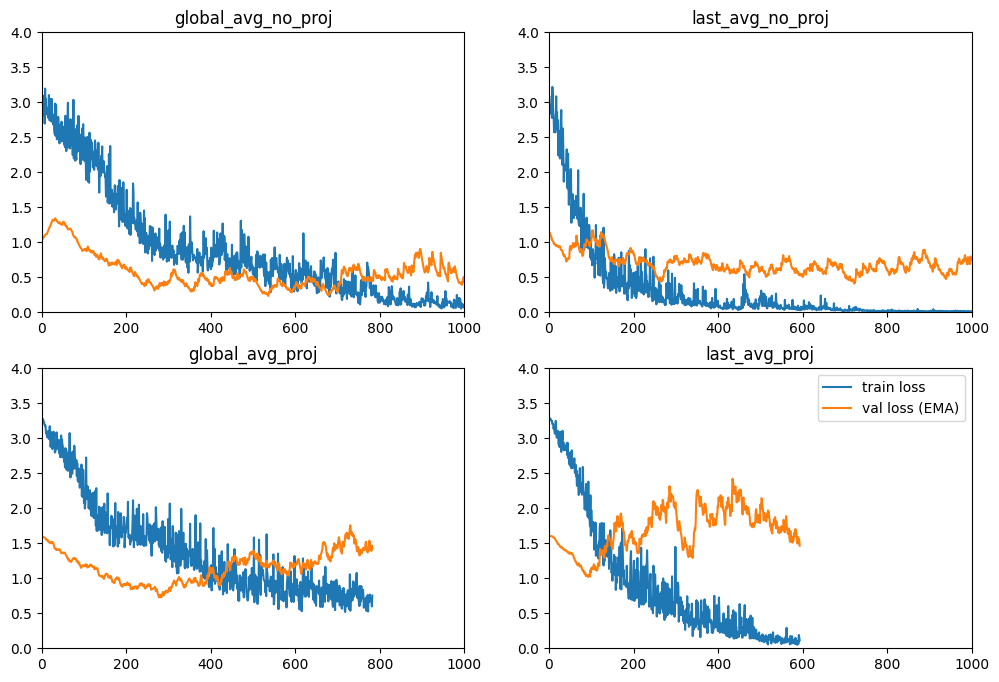

In [50]:
# Plot results
plt.figure(figsize=(12, 8))
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, (name, history) in enumerate(histories.items()):
    row = i // 2
    col = i % 2
    axs[row, col].plot(history['train_loss'], label='train loss')
    axs[row, col].plot(history['ema_val_loss'], label='val loss (EMA)')
    axs[row, col].set_title(name)
    axs[row, col].set_ylim(0, 1)

# Set the same y-axis limits for all plots
for ax in axs.flat:
    ax.set_ylim(0, 4)
    ax.set_xlim(0,1000)

plt.legend()
plt.show()

In [51]:
# Evaluate models
X_train_global_avg_no_proj = torch.cat([cl_global_avg_no_proj.gnn(d) for d in X_train])
X_test_global_avg_no_proj = torch.cat([cl_global_avg_no_proj.gnn(d) for d in X_test])

X_train_last_avg_no_proj = torch.cat([cl_last_avg_no_proj.gnn(d) for d in X_train])
X_test_last_avg_no_proj = torch.cat([cl_last_avg_no_proj.gnn(d) for d in X_test])

X_train_global_avg_proj = torch.cat([cl_global_avg_proj.gnn(d) for d in X_train])
X_test_global_avg_proj = torch.cat([cl_global_avg_proj.gnn(d) for d in X_test])

X_train_last_avg_proj = torch.cat([cl_last_avg_proj.gnn(d) for d in X_train])
X_test_last_avg_proj = torch.cat([cl_last_avg_proj.gnn(d) for d in X_test])

print("True labels:")
print(y_test)
print("\n")

# WITHOUT PROJECTION HEAD
print("--- WITHOUT PROJECTION HEAD ---")
print("Global avg pooling")
classifier_global_avg_no_proj = LogisticRegression().fit(X_train_global_avg_no_proj.detach().numpy(), y_train)
y_pred = classifier_global_avg_no_proj.predict(X_test_global_avg_no_proj.detach().numpy())
print(f"Predicted probabilities:\n {classifier_global_avg_no_proj.predict_proba(X_test_global_avg_no_proj.detach().numpy())}")
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

print("Last avg pooling")
classifier_last_avg_no_proj = LogisticRegression().fit(X_train_last_avg_no_proj.detach().numpy(), y_train)
y_pred = classifier_last_avg_no_proj.predict(X_test_last_avg_no_proj.detach().numpy())
print(f"Predicted probabilities:\n {classifier_last_avg_no_proj.predict_proba(X_test_last_avg_no_proj.detach().numpy())}")
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

# WITH PROJECTION HEAD
print("--- WITH PROJECTION HEAD ---")
print("Global avg pooling")
classifier_global_avg_proj = LogisticRegression().fit(X_train_global_avg_proj.detach().numpy(), y_train)
y_pred = classifier_global_avg_proj.predict(X_test_global_avg_proj.detach().numpy())
print(f"Predicted probabilities:\n {classifier_global_avg_proj.predict_proba(X_test_global_avg_proj.detach().numpy())}")
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

print("Last avg pooling")
classifier_last_avg_proj = LogisticRegression().fit(X_train_last_avg_proj.detach().numpy(), y_train)
y_pred = classifier_last_avg_proj.predict(X_test_last_avg_proj.detach().numpy())
print(f"Predicted probabilities:\n {classifier_last_avg_proj.predict_proba(X_test_last_avg_proj.detach().numpy())}")
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

True labels:
tensor([1, 0])


--- WITHOUT PROJECTION HEAD ---
Global avg pooling
Predicted probabilities:
 [[0.50031462 0.49968538]
 [0.50041597 0.49958403]]
Accuracy of the classifier: 0.5
Last avg pooling
Predicted probabilities:
 [[0.50011514 0.49988486]
 [0.49995568 0.50004432]]
Accuracy of the classifier: 0.0
--- WITH PROJECTION HEAD ---
Global avg pooling
Predicted probabilities:
 [[0.29843695 0.70156305]
 [0.64610849 0.35389151]]
Accuracy of the classifier: 1.0
Last avg pooling
Predicted probabilities:
 [[0.48908949 0.51091051]
 [0.50800143 0.49199857]]
Accuracy of the classifier: 1.0


In [52]:
# do the same with higher temperature
temperature = 0.5

proj_global = torch.nn.Sequential(
    torch.nn.Linear(out_dim_gnn, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, proj_out_dim),
)

proj_last = torch.nn.Sequential(
    torch.nn.Linear(out_dim_gnn, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, proj_out_dim),
)

gnn_global_avg_no_proj = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy='global_avg')
gnn_last_avg_no_proj = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy='last_avg')
gnn_global_avg_proj = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy='global_avg')
gnn_last_avg_proj = GCNFeatureExtractor(in_channels=n_features, out_channels=out_dim_gnn, pooling_strategy='last_avg')

cl_global_avg_no_proj = CLWrapper(gnn_global_avg_no_proj).to(device)
cl_last_avg_no_proj = CLWrapper(gnn_last_avg_no_proj).to(device)

cl_global_avg_proj = CLWrapper(gnn_global_avg_proj, proj_global).to(device)
cl_last_avg_proj = CLWrapper(gnn_last_avg_proj, proj_last).to(device)

histories = {}

# Train models
for model, name in [(cl_global_avg_no_proj, 'global_avg_no_proj'), 
                     (cl_last_avg_no_proj, 'last_avg_no_proj'),
                     (cl_global_avg_proj, 'global_avg_proj'),
                     (cl_last_avg_proj, 'last_avg_proj')]:
    print(f"Training model: {name}")
    history = train(model, train_dataset, val_dataset,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    lr=learning_rate,
                    tau= temperature, 
                    device=device,
                    ema_alpha= alpha,
                    patience=patience, 
                    verbose=False)
    histories[name] = history


Training model: global_avg_no_proj


Training:  37%|███▋      | 932/2500 [00:57<01:36, 16.18epoch/s, loss=1.6523, val_loss=0.7110, ema_val_loss=0.9523]


Early stopping due to no improvement in validation loss. Epochs run:  932
Restoring model to the state with the best validation loss.
Training model: last_avg_no_proj


Training:  34%|███▍      | 852/2500 [00:53<01:43, 15.93epoch/s, loss=1.5158, val_loss=1.3527, ema_val_loss=1.0301]


Early stopping due to no improvement in validation loss. Epochs run:  852
Restoring model to the state with the best validation loss.
Training model: global_avg_proj


Training:  69%|██████▊   | 1713/2500 [01:43<00:47, 16.53epoch/s, loss=1.6254, val_loss=0.7248, ema_val_loss=1.0149]


Early stopping due to no improvement in validation loss. Epochs run:  1713
Restoring model to the state with the best validation loss.
Training model: last_avg_proj


Training:  28%|██▊       | 711/2500 [00:44<01:50, 16.13epoch/s, loss=1.6189, val_loss=1.3523, ema_val_loss=1.4042]

Early stopping due to no improvement in validation loss. Epochs run:  711
Restoring model to the state with the best validation loss.


<Figure size 1200x800 with 0 Axes>

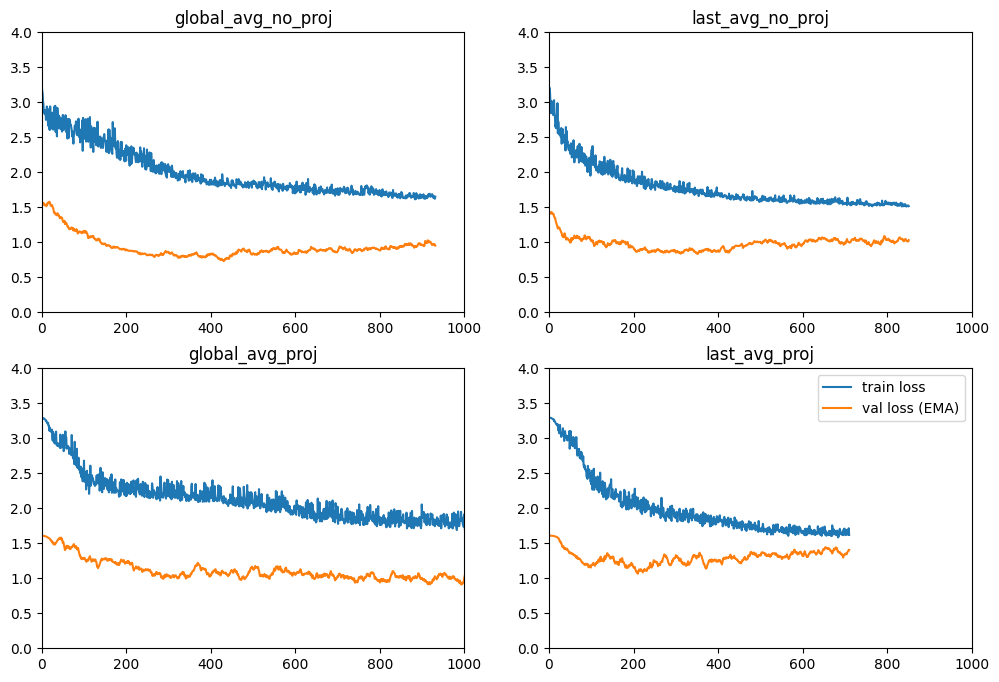

In [53]:
# Plot results
plt.figure(figsize=(12, 8))
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, (name, history) in enumerate(histories.items()):
    row = i // 2
    col = i % 2
    axs[row, col].plot(history['train_loss'], label='train loss')
    axs[row, col].plot(history['ema_val_loss'], label='val loss (EMA)')
    axs[row, col].set_title(name)
    axs[row, col].set_ylim(0, 4)
    axs[row, col].set_xlim(0,1000)

plt.legend()
plt.show()

In [54]:
# Evaluate models
X_train_global_avg_no_proj = torch.cat([cl_global_avg_no_proj.gnn(d) for d in X_train])
X_test_global_avg_no_proj = torch.cat([cl_global_avg_no_proj.gnn(d) for d in X_test])

X_train_last_avg_no_proj = torch.cat([cl_last_avg_no_proj.gnn(d) for d in X_train])
X_test_last_avg_no_proj = torch.cat([cl_last_avg_no_proj.gnn(d) for d in X_test])

X_train_global_avg_proj = torch.cat([cl_global_avg_proj.gnn(d) for d in X_train])
X_test_global_avg_proj = torch.cat([cl_global_avg_proj.gnn(d) for d in X_test])

X_train_last_avg_proj = torch.cat([cl_last_avg_proj.gnn(d) for d in X_train])
X_test_last_avg_proj = torch.cat([cl_last_avg_proj.gnn(d) for d in X_test])

print("True labels:")
print(y_test)
print("\n")

# WITHOUT PROJECTION HEAD
print("--- WITHOUT PROJECTION HEAD ---")
print("Global avg pooling")
classifier_global_avg_no_proj = LogisticRegression().fit(X_train_global_avg_no_proj.detach().numpy(), y_train)
y_pred = classifier_global_avg_no_proj.predict(X_test_global_avg_no_proj.detach().numpy())
print(f"Predicted probabilities:\n {classifier_global_avg_no_proj.predict_proba(X_test_global_avg_no_proj.detach().numpy())}")
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

print("Last avg pooling")
classifier_last_avg_no_proj = LogisticRegression().fit(X_train_last_avg_no_proj.detach().numpy(), y_train)
y_pred = classifier_last_avg_no_proj.predict(X_test_last_avg_no_proj.detach().numpy())
print(f"Predicted probabilities:\n {classifier_last_avg_no_proj.predict_proba(X_test_last_avg_no_proj.detach().numpy())}")
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

# WITH PROJECTION HEAD
print("--- WITH PROJECTION HEAD ---")
print("Global avg pooling")
classifier_global_avg_proj = LogisticRegression().fit(X_train_global_avg_proj.detach().numpy(), y_train)
y_pred = classifier_global_avg_proj.predict(X_test_global_avg_proj.detach().numpy())
print(f"Predicted probabilities:\n {classifier_global_avg_proj.predict_proba(X_test_global_avg_proj.detach().numpy())}")
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

print("Last avg pooling")
classifier_last_avg_proj = LogisticRegression().fit(X_train_last_avg_proj.detach().numpy(), y_train)
y_pred = classifier_last_avg_proj.predict(X_test_last_avg_proj.detach().numpy())
print(f"Predicted probabilities:\n {classifier_last_avg_proj.predict_proba(X_test_last_avg_proj.detach().numpy())}")
print(f"Accuracy of the classifier: {accuracy_score(y_test, y_pred)}")

True labels:
tensor([1, 0])


--- WITHOUT PROJECTION HEAD ---
Global avg pooling
Predicted probabilities:
 [[0.50030493 0.49969507]
 [0.50027834 0.49972166]]
Accuracy of the classifier: 0.5
Last avg pooling
Predicted probabilities:
 [[0.50012469 0.49987531]
 [0.50007575 0.49992425]]
Accuracy of the classifier: 0.5
--- WITH PROJECTION HEAD ---
Global avg pooling
Predicted probabilities:
 [[0.30172921 0.69827079]
 [0.62166971 0.37833029]]
Accuracy of the classifier: 1.0
Last avg pooling
Predicted probabilities:
 [[0.48814098 0.51185902]
 [0.5143551  0.4856449 ]]
Accuracy of the classifier: 1.0
